# Dynamics of Image Embedding during Evolution w.r.t. reference dataset

In this notebook, we explore how the image embedding of generated images evolved over Evolution, esp. with respect to natural image manifold exemplified by some reference datasets (BigGAN, DeePSim, ImageNet images). 

We are going to compute a batch of statistics for the embedding vector, 
* Mahalanobis distance to the center of an approximated Gaussian distribution
* Negative log likelihood of this sample given a Gaussian approximation to the reference dataset.
* Distance to the nearest neighbor in that dataset. (similar to k-NN density approximation)
* Mahalanobis distance to the nearest neighbor in that dataset. (preconditioning by the eigen spectra of the target dataset.)


## Set up

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys
import glob
import math
import torch
import pickle as pkl
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
sys.path.append("/n/home12/binxuwang/Github/Neuro-ActMax-GAN-comparison")

In [3]:
tabdir = r"/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_Project/Stats_tables"
meta_df = pd.read_csv(join(tabdir, "meta_activation_stats_w_optimizer.csv"), index_col=0)

In [4]:
meta_df.shape

(170, 49)

### Distance and Plot functions

In [5]:
# compute mahalanobis distance
def mahalanobis_sqdist(x, mean, eigvec, eigval, eigfloor=1e-5, device="cuda"):
    x = x.to(device) - mean[None, :].to(device)
    # rotate
    rot_x = x @ eigvec
    # scale
    return (rot_x ** 2 / torch.clamp(eigval[None, :].to(device), min=eigfloor)).sum(dim=1)


# plot functions to collect activation / distace according to gens. 
def compute_mean_var(x, gen_vec, var="std"):
    meanvec = []
    errvec = []
    for gen in range(gen_vec.min(), gen_vec.max()+1):
        meanvec.append(x[gen_vec==gen].mean())
        if var == "std":
            errvec.append(x[gen_vec==gen].std())
        elif var == "var":
            errvec.append(x[gen_vec==gen].var())
        elif var == "sem":
            errvec.append(x[gen_vec==gen].std() / np.sqrt((gen_vec==gen).sum()))
    return torch.tensor(meanvec), torch.tensor(errvec)

def plot_shaded_errorbar(x, y, color="b", label="", var="std", **kwargs):
    meanvec, errvec = compute_mean_var(y, x, var=var)
    plt.plot(np.unique(x), meanvec, color=color, label=label, **kwargs)
    plt.fill_between(np.unique(x), meanvec-errvec, meanvec+errvec, color=color, alpha=0.3)

In [6]:
def gaussian_nll_with_eig(x, mean, eigvals, eigvecs, eigfloor=1E-3, device="cuda"):
    """
    Calculate the Gaussian negative log likelihood of x given the mean, eigenvalues, and eigenvectors.

    Args:
        x (torch.Tensor): Input tensor of shape (batch_size, input_dim).
        mean (torch.Tensor): Mean tensor of shape (input_dim,).
        eigvals (torch.Tensor): Eigenvalues tensor of shape (input_dim,).
        eigvecs (torch.Tensor): Eigenvectors tensor of shape (input_dim, input_dim).

    Returns:
        torch.Tensor: Gaussian negative log likelihood tensor of shape (batch_size,).
    """
    input_dim = x.size(1)
    diff = x - mean
    eigvals_clamped = torch.clamp(eigvals.to(device), min=eigfloor)
    mahalanobis = torch.matmul(diff, eigvecs)
    mahalanobis = mahalanobis**2 / eigvals_clamped
    mahalanobis = torch.sum(mahalanobis, dim=1)
    log_det = torch.sum(torch.log(eigvals_clamped))
    nll = 0.5 * (input_dim * math.log(2 * math.pi) + log_det + mahalanobis)
    return nll


In [14]:
def dist2k_nearest_neighbor(probe_embed, ref_embed, k_list, device="cuda"):
    """
    Calculate the Euclidean distance between a probe embedding and the k nearest neighbors in a reference embedding.

    Args:
        probe_embed (torch.Tensor): Embedding tensor of shape (probe_size, embedding_dim).
        ref_embed (torch.Tensor): Reference embedding tensor of shape (ref_size, embedding_dim).
        k_list (list): List of integers specifying the number of nearest neighbors to consider.
        device (str): Device to perform the calculations on (default is "cuda").

    Returns:
        dict: Dictionary containing the distances to the k nearest neighbors for each probe embedding.
    """
    probe_embed = probe_embed.to(device)
    ref_embed = ref_embed.to(device)
    dists = torch.cdist(probe_embed, ref_embed,
                            p=2.0, compute_mode='use_mm_for_euclid_dist_if_necessary')
    max_k = max(k_list)
    k_nearest = torch.topk(dists, max_k, largest=False).values
    distances = {}
    for k in k_list:
        distances[k] = k_nearest[:, k-1]
    return distances


In [58]:
def dist2k_nearest_neighbor_mahalanobis(probe_embed, ref_embed, k_list, eigvecs, eigvals, eigfloor=1E-3, device="cuda"):
    """
    Calculate the Euclidean distance between a probe embedding and the k nearest neighbors in a reference embedding.

    Args:
        probe_embed (torch.Tensor): Embedding tensor of shape (probe_size, embedding_dim).
        ref_embed (torch.Tensor): Reference embedding tensor of shape (ref_size, embedding_dim).
        k_list (list): List of integers specifying the number of nearest neighbors to consider.
        device (str): Device to perform the calculations on (default is "cuda").

    Returns:
        dict: Dictionary containing the distances to the k nearest neighbors for each probe embedding.
    """
    probe_embed = probe_embed.to(device)
    ref_embed = ref_embed.to(device)
    scaling = torch.sqrt(torch.clamp(eigvals.to(device), min=eigfloor))
    probe_embed_rot = (probe_embed @ eigvecs) / scaling
    ref_embed_rot = (ref_embed @ eigvecs) / scaling
    dists = torch.cdist(probe_embed_rot, ref_embed_rot,
                            p=2.0, compute_mode='use_mm_for_euclid_dist_if_necessary')
    max_k = max(k_list)
    k_nearest = torch.topk(dists, max_k, largest=False).values
    distances = {}
    for k in k_list:
        distances[k] = k_nearest[:, k-1]
    return distances


### Compute Reference Dataset PC structure

In [8]:
GANembed_root = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/GAN_img_embedding"
GANembed_dir = join(GANembed_root, "dinov2_vitb14")
Evol_embed_dir = '/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_img_embedding/dinov2_vitb14'

def load_compute_eigen(dataset_str):
    if dataset_str == "imagenet_valid":
        embed = pkl.load(open(join(GANembed_dir, dataset_str+"_embedding.pkl"), "rb"))
    else:
        _, embed = pkl.load(open(join(GANembed_dir, dataset_str+"_embedding.pkl"), "rb"))
    embed = embed.cuda()
    cov = torch.cov(embed.T, )
    data_mean = embed.mean(dim=0)
    data_eigvals, data_eigvecs = torch.linalg.eigh(cov)
    data_eigvals = torch.flip(data_eigvals, dims=[0])
    data_eigvecs = torch.flip(data_eigvecs, dims=[1])
    return (data_mean, data_eigvals, data_eigvecs)

def load_dataset_embed(dataset_str):
    if dataset_str == "imagenet_valid":
        embed = pkl.load(open(join(GANembed_dir, dataset_str+"_embedding.pkl"), "rb"))
    else:
        _, embed = pkl.load(open(join(GANembed_dir, dataset_str+"_embedding.pkl"), "rb"))
    return embed

In [26]:
# FC_mean, FC_eigvals, FC_eigvecs = load_compute_eigen("DeePSim_4std")
# BG_mean, BG_eigvals, BG_eigvecs = load_compute_eigen("BigGAN_trunc07")
# BGRND_mean, BGRND_eigvals, BGRND_eigvecs = load_compute_eigen("BigGAN_std_008")
# IN_mean, IN_eigvals, IN_eigvecs = load_compute_eigen("imagenet_valid")
MH_eig_col = {}
for dataset_str in [
    "imagenet_valid",
    "BigGAN_trunc07",
    "BigGAN_std_008",
    "DeePSim_4std",
    "pink_noise",
]:
    MH_eig_col[dataset_str] = load_compute_eigen(dataset_str)

In [28]:
dataset_embed_col = {}
for dataset_str in [
    "imagenet_valid",
    "BigGAN_trunc07",
    "BigGAN_std_008",
    "DeePSim_4std",
    "pink_noise",
]:
    dataset_embed_col[dataset_str] = load_dataset_embed(dataset_str).cuda()

## Dataset distance dist. baselines

Compute the baseline distance structure between the reference dataset samples.

Generally there are two types of metrics, local distance measures or global distance measures
* **Global distance**: NLL & MHdistance are assuming the whole point cloud is Multivariate Gaussian, then evaluate the distance to the distribution center considering the Gaussian covariance.
* **Local distance**: KNN and MHKnn are local measures, considering the distance to the nearest points in the reference dataset. kNN assume isotropy in the embedding space; Mahalanobis kNN assumes the embedding space has the geometry defined by the global covariance of the Gaussian. 

In [ ]:
# baselines 
df_col = []
for baseline_str in ["imagenet_valid", "BigGAN_trunc07", "BigGAN_std_008", "DeePSim_4std"]:
    # embeddings from the baseline dataset
    embeddings_ref = load_dataset_embed(baseline_str)
    for dataset_str in MH_eig_col:
        # compute distance to the PCdataset based on PC of the PCdataset 
        data_mean, data_eigvals, data_eigvecs = MH_eig_col[dataset_str]
        dataset_embed = load_dataset_embed(dataset_str)
        MHdist_ref = mahalanobis_sqdist(embeddings_ref.cuda(), data_mean, data_eigvecs, data_eigvals, eigfloor=1e-3).cpu()
        kNNdist_ref = dist2k_nearest_neighbor(embeddings_ref, dataset_embed, k_list=[1, 5, 10, 25, 50])
        kNNMHdist_ref = dist2k_nearest_neighbor_mahalanobis(embeddings_ref, dataset_embed, [1, 5, 10, 25, 50],
                                                            data_eigvecs, data_eigvals, eigfloor=1e-3)
        ref_dist_col = {}
        ref_dist_col["baseline"] = baseline_str
        ref_dist_col["PC_dataset"] = dataset_str
        ref_dist_col["MHdist"] = MHdist_ref.numpy()
        for k in kNNdist_ref:
            ref_dist_col[f"kNNdist_{k}"] = kNNdist_ref[k].cpu().numpy()
            ref_dist_col[f"kNNMHdist_{k}"] = kNNMHdist_ref[k].cpu().numpy()
        df = pd.DataFrame(ref_dist_col)
        df_col.append(df)
df_total = pd.concat(df_col, ignore_index=True)

In [104]:
df_total.to_csv(join(tabdir, "reference_dataset_DINO_embed_MHdist_all.csv"))

<Axes: xlabel='PC_dataset', ylabel='kNNMHdist_25'>

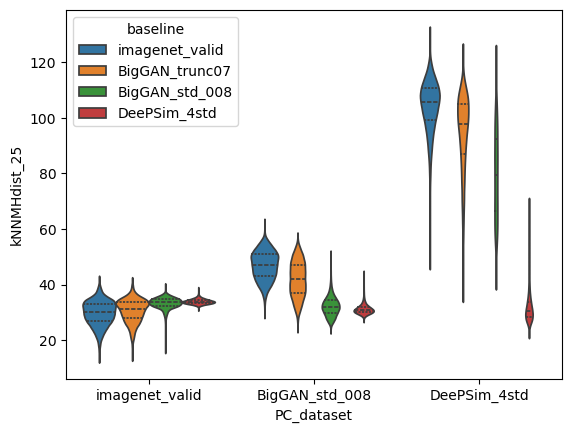

In [83]:
sns.violinplot(data=df_total, x="PC_dataset", y="kNNMHdist_25", hue="baseline", 
               order=["imagenet_valid", "BigGAN_std_008", "DeePSim_4std"], #"BigGAN_trunc07", "BigGAN_std_008", "DeePSim_4std"
               hue_order=["imagenet_valid", "BigGAN_trunc07", "BigGAN_std_008", "DeePSim_4std"],
               split=False, inner="quartile")

<Axes: xlabel='PC_dataset', ylabel='kNNdist_25'>

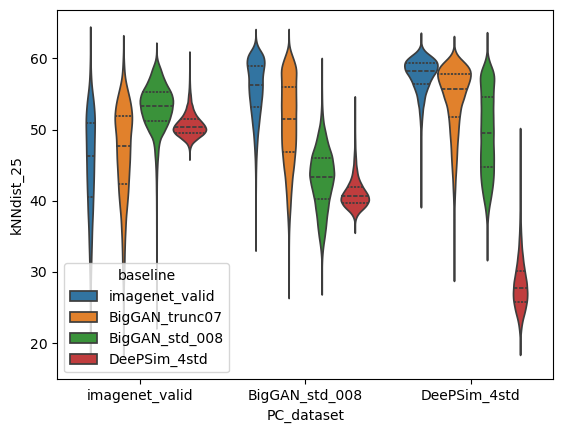

In [105]:
sns.violinplot(data=df_total, x="PC_dataset", y="kNNdist_25", hue="baseline", 
               order=["imagenet_valid", "BigGAN_std_008", "DeePSim_4std"], #"BigGAN_trunc07", "BigGAN_std_008", "DeePSim_4std"
               hue_order=["imagenet_valid", "BigGAN_trunc07", "BigGAN_std_008", "DeePSim_4std"],
               split=False, inner="quartile")

<Axes: xlabel='PC_dataset', ylabel='kNNMHdist_50'>

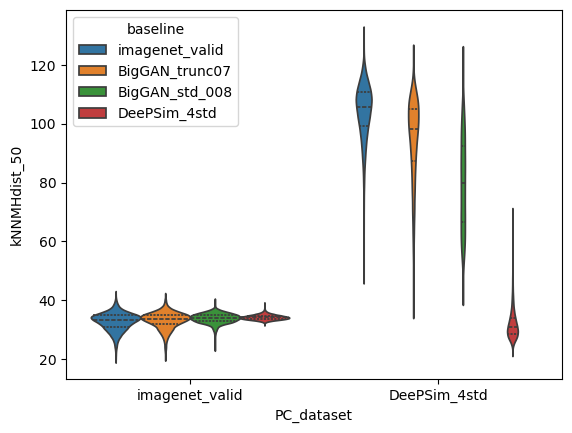

In [94]:
sns.violinplot(data=df_total, x="PC_dataset", y="kNNMHdist_50", hue="baseline", 
               order=["imagenet_valid", "DeePSim_4std"], 
               hue_order=["imagenet_valid", "BigGAN_trunc07", "BigGAN_std_008", "DeePSim_4std"],
               split=False, inner="quartile")

In [95]:
df_total.groupby(["baseline", "PC_dataset"], sort=False).mean()

MHdist  kNNdist_1  kNNMHdist_1  \
baseline       PC_dataset                                             
imagenet_valid imagenet_valid  7.669849e+02   0.017555     0.010559   
               BigGAN_trunc07  1.172249e+03  41.033138    31.475887   
               BigGAN_std_008  1.992977e+03  49.404121    43.495720   
               DeePSim_4std    1.097895e+04  55.930874   102.249161   
               pink_noise      1.161598e+06  64.253807  1070.472900   
BigGAN_trunc07 imagenet_valid  7.754193e+02  39.196125    26.173273   
               BigGAN_trunc07  7.669850e+02   0.017349     0.010534   
               BigGAN_std_008  1.556016e+03  42.912834    37.480881   
               DeePSim_4std    9.144888e+03  52.322266    92.793991   
               pink_noise      1.106762e+06  62.868679  1043.611206   
BigGAN_std_008 imagenet_valid  7.466710e+02  48.583401    31.180338   
               BigGAN_trunc07  7.631931e+02  42.356819    30.289633   
               BigGAN_std_008  7.669850e+02   0.016654     0.010683   
               DeePSim_4std    6.490394e+03  47.744808    78.554764   
               pink_noise      1.037901e+06  60.978539  1010.014465   
DeePSim_4std   imagenet_valid  7.369121e+02  46.615810    31.912107   
               BigGAN_trunc07  5.616245e+02  37.310741    27.172159   
               BigGAN_std_008  6.894410e+02  38.095329    29.843237   
               DeePSim_4std    7.669851e+02   0.014703     0.015863   
               pink_noise      6.013430e+05  51.004421   766.210510   

                               kNNdist_5  kNNMHdist_5  kNNdist_10  \
baseline       PC_dataset                                           
imagenet_valid imagenet_valid  38.101162    25.442848   40.784283   
               BigGAN_trunc07  43.614735    33.220684   44.949841   
               BigGAN_std_008  52.841801    45.603081   54.132050   
               DeePSim_4std    56.949856   103.548286   57.274326   
               pink_noise      64.807198  1072.153198   65.045868   
BigGAN_trunc07 imagenet_valid  42.002735    27.875862   43.555843   
               BigGAN_trunc07  32.324566    24.654257   34.126831   
               BigGAN_std_008  47.293892    40.265949   48.973789   
               DeePSim_4std    53.456848    94.058533   53.817829   
               pink_noise      63.464512  1045.510620   63.734211   
BigGAN_std_008 imagenet_valid  50.764118    32.284691   51.712635   
               BigGAN_trunc07  44.562634    31.454437   45.528503   
               BigGAN_std_008  39.927792    30.995407   41.303356   
               DeePSim_4std    48.759541    79.218651   49.115929   
               pink_noise      61.655945  1012.079224   62.006149   
DeePSim_4std   imagenet_valid  48.554298    32.924831   49.410809   
               BigGAN_trunc07  39.270988    28.166845   40.043724   
               BigGAN_std_008  39.587708    30.482096   40.205173   
               DeePSim_4std    27.198690    31.021587   27.638178   
               pink_noise      51.983284   768.548401   52.418655   

                               kNNMHdist_10  kNNdist_25  kNNMHdist_25  \
baseline       PC_dataset                                               
imagenet_valid imagenet_valid     27.067245   45.307720     29.706253   
               BigGAN_trunc07     34.096268   47.397259     35.637627   
               BigGAN_std_008     46.248524   55.702541     46.898819   
               DeePSim_4std      103.888123   57.664635    104.237587   
               pink_noise       1072.656738   65.287643   1073.220459   
BigGAN_trunc07 imagenet_valid     28.801477   46.730324     30.638498   
               BigGAN_trunc07     25.865746   37.353352     27.952417   
               BigGAN_std_008     41.117004   51.050056     41.948715   
               DeePSim_4std       94.378403   54.261181     94.716660   
               pink_noise       1046.036499   63.993126   1046.613892   
BigGAN_std_008 imagenet_valid     32.737179   53.128880     33.376690   
      

## Massive Compute 

Compute the distance of evolved images to different reference dataset and with various measures.

In [84]:
# compute mahalanobis distance for all Exps
stats_df_col = []
for Expi in tqdm(range(1, 190+1)):
    # if ~ os.path.exists(join(Evol_embed_dir, f"Exp{Expi}_embed_act_data.pkl")):
    #     continue
    if Expi not in meta_df.index:
        continue
    meta_dict = meta_df.loc[Expi][['Animal', 'expdate', 'ephysFN', 'prefchan', 'prefunit', 'visual_area',
       'space1', 'space2', 'optim_names1', 'optim_names2', 'blockN']].to_dict()
    Evol_data = pkl.load(open(join(Evol_embed_dir, f"Exp{Expi:03d}_embed_act_data.pkl"), "rb"))
    for thread in [0, 1]:
        stats_col = {}
        embeddings = Evol_data[f"embeddings{thread}"]
        gen_vec = Evol_data[f"gen_vec{thread}"]
        resp_mat = Evol_data[f"resp_mat{thread}"]
        stats_col["Expi"] = Expi
        stats_col["thread"] = thread
        stats_col["generation"] = gen_vec
        stats_col["resp_mean"] = resp_mat[:, 0]
        for dataset_str in MH_eig_col:
            data_mean, data_eigvals, data_eigvecs = MH_eig_col[dataset_str]
            dataset_embed = dataset_embed_col[dataset_str]
            MHdist_thread = mahalanobis_sqdist(embeddings.cuda(), data_mean, data_eigvecs, data_eigvals, eigfloor=1e-3).cpu()
            NLL_thread = gaussian_nll_with_eig(embeddings.cuda(), data_mean, data_eigvals, data_eigvecs, eigfloor=1e-3).cpu()
            kNNdist = dist2k_nearest_neighbor(embeddings.cuda(), dataset_embed, k_list=[1, 5, 10, 25, 50])
            KNNMHdist = dist2k_nearest_neighbor_mahalanobis(embeddings.cuda(), dataset_embed, [1, 5, 10, 25, 50],
                                                            data_eigvecs, data_eigvals, eigfloor=1e-3)
            stats_col[f"MHdist_{dataset_str}"] = MHdist_thread
            stats_col[f"NLL_{dataset_str}"] = NLL_thread
            for k in kNNdist:
                stats_col[f"kNNdist_{k}_{dataset_str}"] = kNNdist[k].cpu()
                stats_col[f"kNNMHdist_{k}_{dataset_str}"] = KNNMHdist[k].cpu()
        stats_col.update(meta_dict)
        stats_df = pd.DataFrame(stats_col)
        stats_df_col.append(stats_df)
    # raise RuntimeError("Stop here")
stats_df_all = pd.concat(stats_df_col, ignore_index=True)

100%|██████████| 190/190 [00:32<00:00,  5.85it/s]


In [85]:
stats_df_all.to_csv(join(tabdir, "Evol_img_DINO_embed_MHdist_all.csv"))

In [86]:
stats_df_all.columns

Index(['Expi', 'thread', 'generation', 'resp_mean', 'MHdist_imagenet_valid',
       'NLL_imagenet_valid', 'kNNdist_1_imagenet_valid',
       'kNNMHdist_1_imagenet_valid', 'kNNdist_5_imagenet_valid',
       'kNNMHdist_5_imagenet_valid', 'kNNdist_10_imagenet_valid',
       'kNNMHdist_10_imagenet_valid', 'kNNdist_25_imagenet_valid',
       'kNNMHdist_25_imagenet_valid', 'kNNdist_50_imagenet_valid',
       'kNNMHdist_50_imagenet_valid', 'MHdist_BigGAN_trunc07',
       'NLL_BigGAN_trunc07', 'kNNdist_1_BigGAN_trunc07',
       'kNNMHdist_1_BigGAN_trunc07', 'kNNdist_5_BigGAN_trunc07',
       'kNNMHdist_5_BigGAN_trunc07', 'kNNdist_10_BigGAN_trunc07',
       'kNNMHdist_10_BigGAN_trunc07', 'kNNdist_25_BigGAN_trunc07',
       'kNNMHdist_25_BigGAN_trunc07', 'kNNdist_50_BigGAN_trunc07',
       'kNNMHdist_50_BigGAN_trunc07', 'MHdist_BigGAN_std_008',
       'NLL_BigGAN_std_008', 'kNNdist_1_BigGAN_std_008',
       'kNNMHdist_1_BigGAN_std_008', 'kNNdist_5_BigGAN_std_008',
       'kNNMHdist_5_BigGAN_std_

## All Session Synopsis

In [32]:
stats_df_all = pd.read_csv(join(tabdir, "Evol_img_DINO_embed_MHdist_all.csv"), index_col=0)

In [33]:
stats_df_all.head()

,Expi,thread,generation,resp_mean,MHdist_imagenet_valid,NLL_imagenet_valid,kNNdist_1_imagenet_valid,kNNdist_5_imagenet_valid,kNNdist_10_imagenet_valid,kNNdist_25_imagenet_valid,...,expdate,ephysFN,prefchan,prefunit,visual_area,space1,space2,optim_names1,optim_names2,blockN
0,3,0,1,159.850917,764.91956,1391.4739,49.656757,51.799873,52.273260,53.515760,...,2020-07-22,Beto-22072020-002,5,2,IT,fc6,BigGAN_class,CMAES,CMAES,47
1,3,0,1,105.139166,860.58057,1439.3044,48.584103,50.716000,51.139095,52.656975,...,2020-07-22,Beto-22072020-002,5,2,IT,fc6,BigGAN_class,CMAES,CMAES,47
2,3,0,1,114.781936,648.80530,1333.4167,44.129807,45.854916,46.866890,47.897938,...,2020-07-22,Beto-22072020-002,5,2,IT,fc6,BigGAN_class,CMAES,CMAES,47
3,3,0,1,113.217269,670.94580,1344.4870,42.653053,44.982975,46.353670,47.720314,...,2020-07-22,Beto-22072020-002,5,2,IT,fc6,BigGAN_class,CMAES,CMAES,47
4,3,0,1,204.278660,752.60110,1385.3147,50.152756,51.948975,52.809990,53.988697,...,2020-07-22,Beto-22072020-002,5,2,IT,fc6,BigGAN_class,CMAES,CMAES,47


### Get Session Masks

In [34]:
from neuro_data_analysis.neural_data_utils import get_all_masks
Amsk, Bmsk, V1msk, V4msk, ITmsk, length_msk, spc_msk, \
    sucsmsk, bsl_unstable_msk, bsl_stable_msk, validmsk = get_all_masks(meta_df)
mask_dict = get_all_masks(meta_df, return_type=dict)
FCsucs_msk = meta_df.p_maxinit_0 < 0.05 
BGsucs_msk = meta_df.p_maxinit_1 < 0.05
bothsucs_msk = FCsucs_msk & BGsucs_msk
anysucs_msk = FCsucs_msk | BGsucs_msk

total number of experiments: 170
total number of valid experiments: 154
total number of valid experiments with suc: 133
Exluded:
  - short: 8
  - unstable baseline: 6
  - not fc6-BigGAN: 3
total number of experiments: 170
total number of valid experiments: 154
total number of valid experiments with suc: 133
Exluded:
  - short: 8
  - unstable baseline: 6
  - not fc6-BigGAN: 3


In [26]:
list(meta_df)

['Animal',
 'expdate',
 'ephysFN',
 'prefchan',
 'prefunit',
 'visual_area',
 'space1',
 'space2',
 'optim_names1',
 'optim_names2',
 'blockN',
 't_endinit_0',
 'p_endinit_0',
 't_endinit_1',
 'p_endinit_1',
 't_maxinit_0',
 'p_maxinit_0',
 't_maxinit_1',
 'p_maxinit_1',
 't_maxend_0',
 'p_maxend_0',
 't_maxend_1',
 'p_maxend_1',
 't_FCBG_end_01',
 'p_FCBG_end_01',
 't_FCBG_max_01',
 'p_FCBG_max_01',
 'maxrsp_0_mean',
 'maxrsp_0_std',
 'maxrsp_0_sem',
 'maxrsp_1_mean',
 'maxrsp_1_std',
 'maxrsp_1_sem',
 'endrsp_0_mean',
 'endrsp_0_std',
 'endrsp_0_sem',
 'endrsp_1_mean',
 'endrsp_1_std',
 'endrsp_1_sem',
 'initrsp_0_mean',
 'initrsp_0_std',
 'initrsp_0_sem',
 'initrsp_1_mean',
 'initrsp_1_std',
 'initrsp_1_sem',
 'space_names1',
 'space_names2',
 'optim_names1_y',
 'optim_names2_y']

In [20]:
Expi_masks = meta_df[validmsk].index

In [28]:
Expi_masks = meta_df[validmsk & bothsucs_msk].index

### Rough GroupBy Stats 

In [50]:
stats_df_all.groupby(["visual_area", "thread"])[["NLL_DeePSim_4std", 
                                                "NLL_BigGAN_trunc07", 
                                                "NLL_BigGAN_std_008", 
                                                "NLL_imagenet_valid"]].mean()

NLL_DeePSim_4std  NLL_BigGAN_trunc07  NLL_BigGAN_std_008  \
visual_area thread                                                             
IT          0             907.389709         1228.193726         1152.252441   
            1            4115.888672         1326.638184         1264.182373   
V1          0             840.587769         1224.839966         1149.420288   
            1            3013.536133         1277.641968         1203.742798   
V4          0             843.243164         1226.365112         1153.213867   
            1            3234.308838         1289.146118         1217.587646   

                    NLL_imagenet_valid  
visual_area thread                      
IT          0              1393.744385  
            1              1389.596436  
V1          0              1394.820435  
            1              1375.331543  
V4          0              1394.499512  
            1              1379.713745

In [51]:
stats_df_all[stats_df_all.Expi.isin(meta_df[validmsk & bothsucs_msk].index)].\
            groupby(["visual_area", "thread"])[["NLL_DeePSim_4std", 
                                                "NLL_BigGAN_trunc07", 
                                                "NLL_BigGAN_std_008", 
                                                "NLL_imagenet_valid"]].mean()

NLL_DeePSim_4std  NLL_BigGAN_trunc07  NLL_BigGAN_std_008  \
visual_area thread                                                             
IT          0             852.661194         1229.201782         1152.918457   
            1            4184.769531         1326.885498         1272.502075   
V1          0             835.433044         1229.087036         1151.809082   
            1            3083.922363         1289.077881         1278.582886   
V4          0             851.630066         1225.626953         1152.172852   
            1            3416.262207         1298.872192         1251.041870   

                    NLL_imagenet_valid  
visual_area thread                      
IT          0              1395.097534  
            1              1390.723511  
V1          0              1397.387207  
            1              1385.892334  
V4          0              1393.409058  
            1              1387.322754

In [34]:
stats_df_all.groupby(["visual_area", "thread"])[["MHdist_DeePSim_4std", 
                                                "MHdist_BigGAN_trunc07", 
                                                "MHdist_BigGAN_std_008", 
                                                "MHdist_imagenet_valid"]].mean()

MHdist_DeePSim_4std  MHdist_BigGAN_trunc07  \
visual_area thread                                               
IT          0               1247.661743             614.068970   
            1               7664.659668             810.957886   
V1          0               1114.057861             607.361633   
            1               5459.954590             712.965515   
V4          0               1119.368774             610.411926   
            1               5901.500000             735.973816   

                    MHdist_BigGAN_std_008  MHdist_imagenet_valid  
visual_area thread                                                
IT          0                  739.571228             769.460327  
            1                  963.431091             761.164429  
V1          0                  733.907043             771.612549  
            1                  842.552063             732.634766  
V4          0                  741.494080             770.970703  
            1                  870.241882             741.399048

### Final Init generation analysis

In [87]:
init_gen_mask  = (stats_df_all.generation > 1) & \
                 (stats_df_all.generation <= 5)
final_gen_mask = (stats_df_all.generation >= stats_df_all.blockN - 5) & \
                 (stats_df_all.generation <= stats_df_all.blockN - 1)

In [97]:
stat_str = "kNNMHdist_10"
stats_df_all[init_gen_mask].groupby(["visual_area", "thread"], sort=False)[[
                                    f"{stat_str}_imagenet_valid",
                                    f"{stat_str}_BigGAN_trunc07", 
                                    f"{stat_str}_BigGAN_std_008", 
                                    f"{stat_str}_DeePSim_4std",  ]].mean()

kNNMHdist_10_imagenet_valid  kNNMHdist_10_BigGAN_trunc07  \
visual_area thread                                                             
IT          0                         33.859966                    29.332689   
            1                         32.698853                    32.239712   
V4          0                         34.073307                    29.565304   
            1                         32.809151                    31.653486   
V1          0                         34.085361                    29.501408   
            1                         32.926956                    31.606895   

                    kNNMHdist_10_BigGAN_std_008  kNNMHdist_10_DeePSim_4std  
visual_area thread                                                          
IT          0                         31.277014                  35.313171  
            1                         32.452198                  79.610359  
V4          0                         31.470081                  35.847546  
            1                         31.826687                  74.049644  
V1          0                         31.440392                  35.781822  
            1                         32.424519                  74.263680

In [101]:
stat_str = "kNNMHdist_10"
session_mask = stats_df_all.Expi.isin(meta_df[validmsk & bothsucs_msk].index)
(stats_df_all[init_gen_mask & session_mask].groupby(["visual_area", "thread"], sort=False)[[
                                    f"{stat_str}_imagenet_valid",
                                    f"{stat_str}_BigGAN_trunc07", 
                                    f"{stat_str}_BigGAN_std_008", 
                                    f"{stat_str}_DeePSim_4std",  ]].mean())

kNNMHdist_10_imagenet_valid  kNNMHdist_10_BigGAN_trunc07  \
visual_area thread                                                             
IT          0                         33.850716                    29.245903   
            1                         32.720455                    32.237869   
V4          0                         34.082481                    29.598274   
            1                         32.904495                    31.909883   
V1          0                         34.158180                    29.812531   
            1                         33.765106                    32.436474   

                    kNNMHdist_10_BigGAN_std_008  kNNMHdist_10_DeePSim_4std  
visual_area thread                                                          
IT          0                         31.230564                  34.421898  
            1                         32.327026                  79.933800  
V4          0                         31.468626                  35.984322  
            1                         32.294601                  75.119675  
V1          0                         31.651165                  36.488045  
            1                         35.771976                  78.232887

In [102]:
stat_str = "kNNMHdist_10"
session_mask = stats_df_all.Expi.isin(meta_df[validmsk & bothsucs_msk].index)
(stats_df_all[final_gen_mask & session_mask].groupby(["visual_area", "thread"], sort=False)[[
                                    f"{stat_str}_imagenet_valid",
                                    f"{stat_str}_BigGAN_trunc07", 
                                    f"{stat_str}_BigGAN_std_008", 
                                    f"{stat_str}_DeePSim_4std",  ]].mean())

kNNMHdist_10_imagenet_valid  kNNMHdist_10_BigGAN_trunc07  \
visual_area thread                                                             
IT          0                         34.045479                    29.992802   
            1                         32.206348                    32.221615   
V4          0                         33.869484                    29.616442   
            1                         32.793835                    31.496864   
V1          0                         33.885654                    29.473989   
            1                         33.694382                    31.762409   

                    kNNMHdist_10_BigGAN_std_008  kNNMHdist_10_DeePSim_4std  
visual_area thread                                                          
IT          0                         31.735668                  36.938255  
            1                         36.258587                  89.187164  
V4          0                         31.561441                  36.208042  
            1                         35.135628                  80.314720  
V1          0                         31.238958                  34.671455  
            1                         34.733528                  71.781731

In [41]:
stats_df_all[final_gen_mask].groupby(["visual_area", "thread"])[["MHdist_imagenet_valid",
                                                                 "MHdist_BigGAN_trunc07", 
                                                "MHdist_BigGAN_std_008", 
                                                "MHdist_DeePSim_4std",  
                                                "MHdist_pink_noise",]].mean()

MHdist_imagenet_valid  MHdist_BigGAN_trunc07  \
visual_area thread                                                 
IT          0                  767.225764             616.874260   
            1                  770.120499             825.455338   
V1          0                  770.336908             611.703659   
            1                  742.800130             707.747824   
V4          0                  767.010955             611.911172   
            1                  745.428460             737.209757   

                    MHdist_BigGAN_std_008  MHdist_DeePSim_4std  \
visual_area thread                                               
IT          0                  741.796172          1250.530512   
            1                 1058.065579          7962.046258   
V1          0                  738.874931          1127.133607   
            1                  883.331542          5216.761201   
V4          0                  745.215941          1113.687793   
            1                  930.014222          6011.707760   

                    MHdist_pink_noise  
visual_area thread                     
IT          0            6.290182e+05  
            1            1.082552e+06  
V1          0            6.134788e+05  
            1            9.853578e+05  
V4          0            6.166497e+05  
            1            1.018839e+06

In [53]:
stat_str = "kNNdist_25" # "MHdist"
stats_df_all[init_gen_mask].groupby(["visual_area","thread"], sort=False)[[
                                                f"{stat_str}_imagenet_valid",
                                                f"{stat_str}_BigGAN_trunc07", 
                                                f"{stat_str}_BigGAN_std_008", 
                                                f"{stat_str}_DeePSim_4std",  
                                                f"{stat_str}_pink_noise",]].mean()

kNNdist_25_imagenet_valid  kNNdist_25_BigGAN_trunc07  \
visual_area thread                                                         
IT          0                       51.410252                  42.223715   
            1                       53.257577                  47.485472   
V4          0                       51.648786                  42.489915   
            1                       53.135911                  46.405770   
V1          0                       51.655728                  42.407477   
            1                       53.244255                  46.378870   

                    kNNdist_25_BigGAN_std_008  kNNdist_25_DeePSim_4std  \
visual_area thread                                                       
IT          0                       41.731365                30.355321   
            1                       44.203431                49.814899   
V4          0                       41.943844                30.782975   
            1                       43.188266                47.597375   
V1          0                       41.912882                30.682227   
            1                       43.828060                47.425369   

                    kNNdist_25_pink_noise  
visual_area thread                         
IT          0                   53.481514  
            1                   62.221210  
V4          0                   53.531867  
            1                   61.401662  
V1          0                   53.443872  
            1                   61.401440

In [51]:
stat_str = "kNNdist_25"
stats_df_all[final_gen_mask].groupby(["visual_area", "thread"], sort=False)[[
                                                f"{stat_str}_imagenet_valid",
                                                f"{stat_str}_BigGAN_trunc07", 
                                                f"{stat_str}_BigGAN_std_008", 
                                                f"{stat_str}_DeePSim_4std",  
                                                f"{stat_str}_pink_noise",]].mean()

kNNdist_25_imagenet_valid  kNNdist_25_BigGAN_trunc07  \
visual_area thread                                                         
IT          0                       51.727057                  42.896742   
            1                       52.892394                  47.783615   
V4          0                       51.647996                  42.669362   
            1                       52.668095                  45.623942   
V1          0                       51.802033                  42.743101   
            1                       53.133123                  45.537344   

                    kNNdist_25_BigGAN_std_008  kNNdist_25_DeePSim_4std  \
visual_area thread                                                       
IT          0                       42.206975                31.492114   
            1                       47.716540                52.954134   
V4          0                       42.109630                30.895872   
            1                       44.613902                48.046056   
V1          0                       42.062532                31.060722   
            1                       44.212465                46.045941   

                    kNNdist_25_pink_noise  
visual_area thread                         
IT          0                   53.983768  
            1                   63.290875  
V4          0                   53.663592  
            1                   61.841798  
V1          0                   53.665405  
            1                   60.862452

In [57]:
stat_str = "MHdist" # "MHdist"
stats_df_all[init_gen_mask].groupby(["visual_area","thread"], sort=False)[[
                                                f"{stat_str}_imagenet_valid",
                                                f"{stat_str}_BigGAN_trunc07", 
                                                f"{stat_str}_BigGAN_std_008", 
                                                f"{stat_str}_DeePSim_4std",  
                                                f"{stat_str}_pink_noise",]].mean()

MHdist_imagenet_valid  MHdist_BigGAN_trunc07  \
visual_area thread                                                 
IT          0                  765.309434             598.264244   
            1                  736.373686             769.112098   
V4          0                  778.180769             609.719142   
            1                  722.733913             725.506343   
V1          0                  778.798245             607.983506   
            1                  726.100718             717.213438   

                    MHdist_BigGAN_std_008  MHdist_DeePSim_4std  \
visual_area thread                                               
IT          0                  723.145745          1101.826661   
            1                  812.698120          6540.564545   
V4          0                  735.547899          1103.695884   
            1                  770.496248          5606.020669   
V1          0                  733.422462          1100.838104   
            1                  805.549213          5632.350891   

                    MHdist_pink_noise  
visual_area thread                     
IT          0            6.068055e+05  
            1            1.029142e+06  
V4          0            6.006091e+05  
            1            9.945582e+05  
V1          0            5.949391e+05  
            1            9.965208e+05

In [56]:
stat_str = "MHdist" # "MHdist"
stats_df_all[final_gen_mask].groupby(["visual_area","thread"], sort=False)[[
                                                f"{stat_str}_imagenet_valid",
                                                f"{stat_str}_BigGAN_trunc07", 
                                                f"{stat_str}_BigGAN_std_008", 
                                                f"{stat_str}_DeePSim_4std",  
                                                f"{stat_str}_pink_noise", ]].mean()

MHdist_imagenet_valid  MHdist_BigGAN_trunc07  \
visual_area thread                                                 
IT          0                  767.225764             616.874260   
            1                  770.120499             825.455338   
V4          0                  767.010955             611.911172   
            1                  745.428460             737.209757   
V1          0                  770.336908             611.703659   
            1                  742.800130             707.747824   

                    MHdist_BigGAN_std_008  MHdist_DeePSim_4std  \
visual_area thread                                               
IT          0                  741.796172          1250.530512   
            1                 1058.065579          7962.046258   
V4          0                  745.215941          1113.687793   
            1                  930.014222          6011.707760   
V1          0                  738.874931          1127.133607   
            1                  883.331542          5216.761201   

                    MHdist_pink_noise  
visual_area thread                     
IT          0            6.290182e+05  
            1            1.082552e+06  
V4          0            6.166497e+05  
            1            1.018839e+06  
V1          0            6.134788e+05  
            1            9.853578e+05

### Evol Trajectory Analysis

Text(0.5, 0, 'Generation')

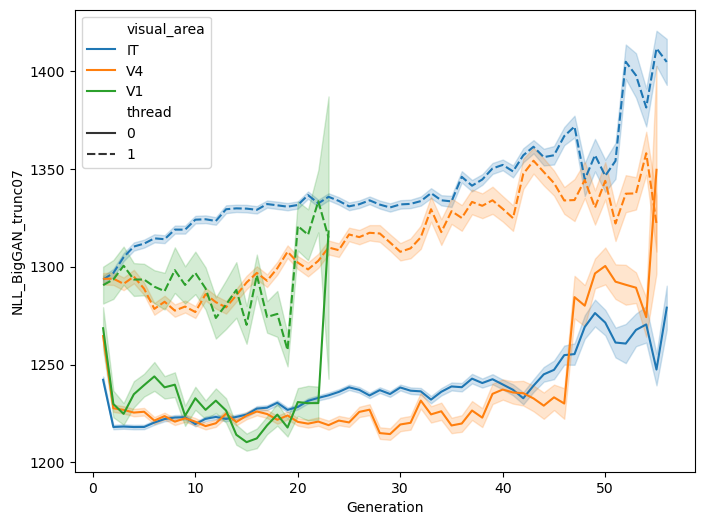

In [54]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="NLL_BigGAN_trunc07", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

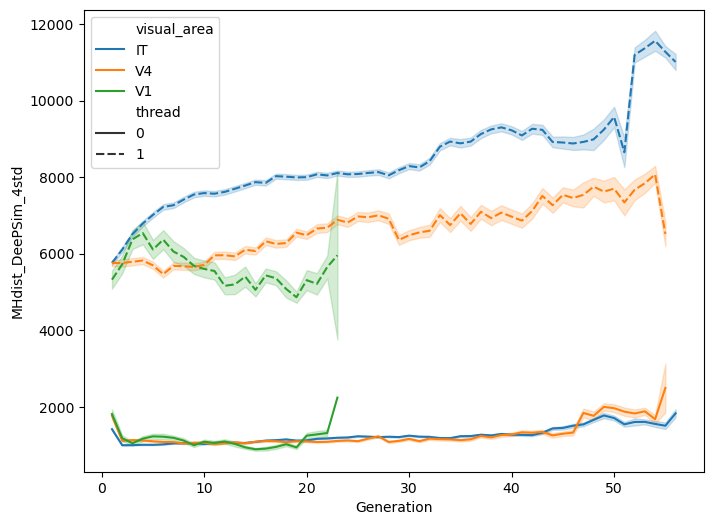

In [32]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="MHdist_DeePSim_4std", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

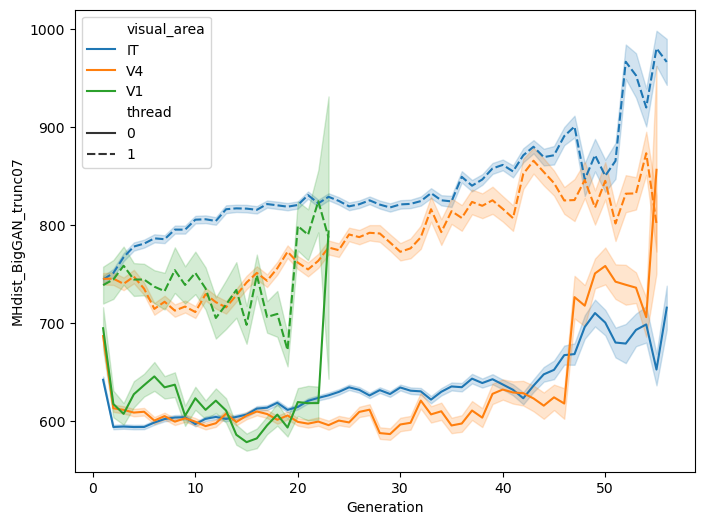

In [30]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="MHdist_BigGAN_trunc07", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

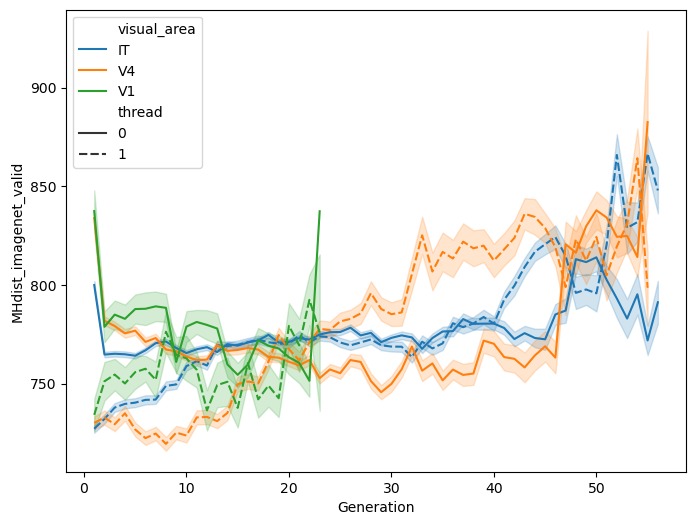

In [29]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="MHdist_imagenet_valid", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

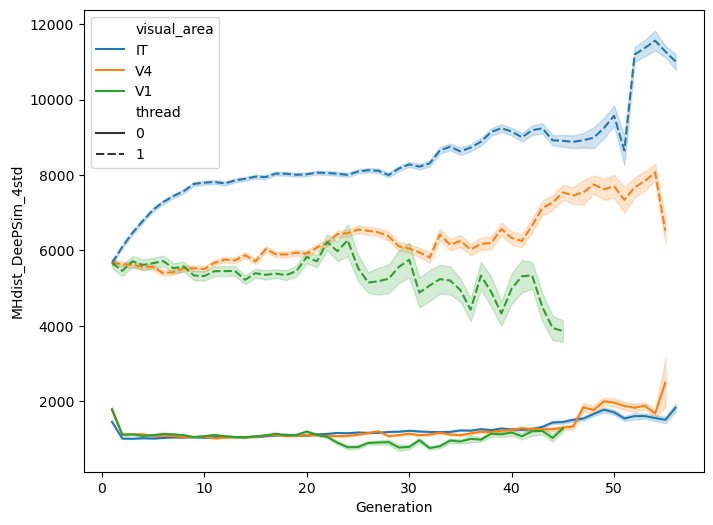

In [23]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="MHdist_DeePSim_4std", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

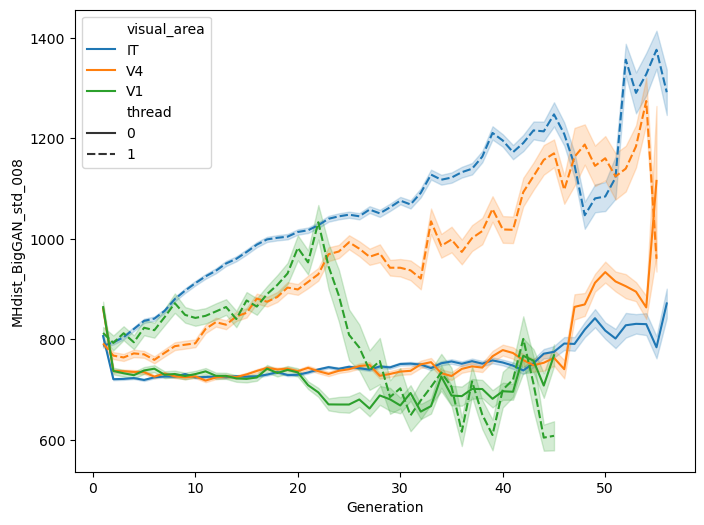

In [25]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="MHdist_BigGAN_std_008", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

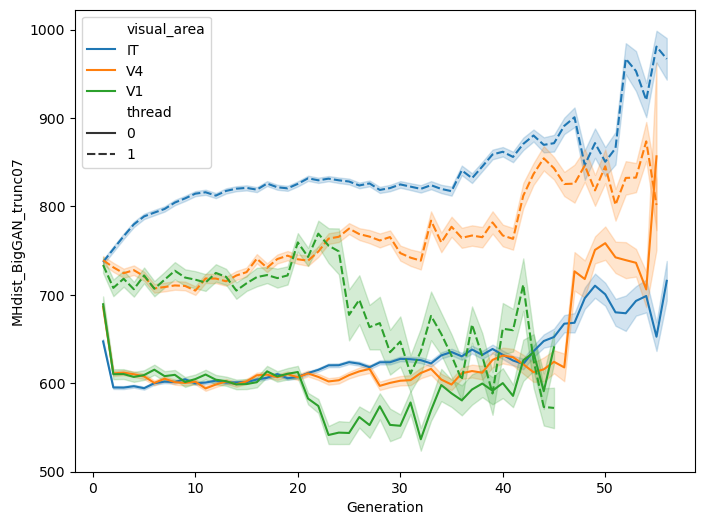

In [24]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="MHdist_BigGAN_trunc07", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

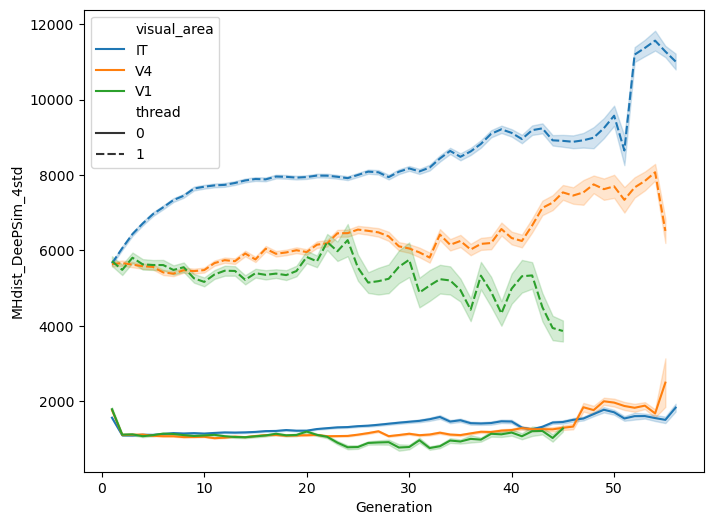

In [22]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all, x="generation", y="MHdist_DeePSim_4std", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

In [ ]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="kNNMHdist_25_BigGAN_trunc07",
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

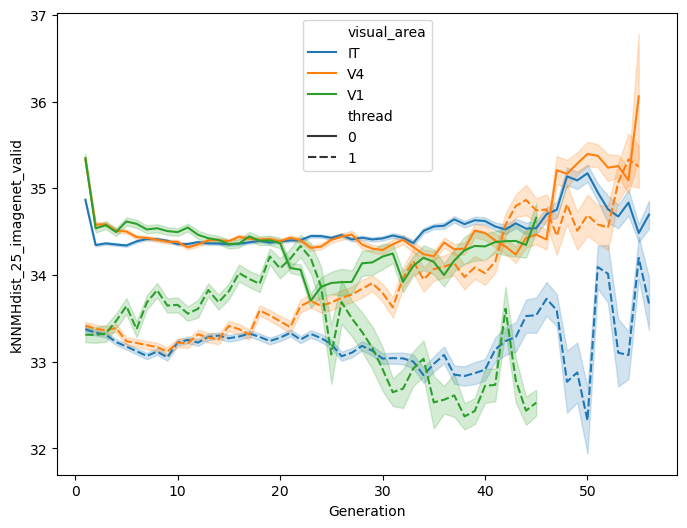

In [106]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="kNNMHdist_25_imagenet_valid", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

## Single Session Analysis Demo

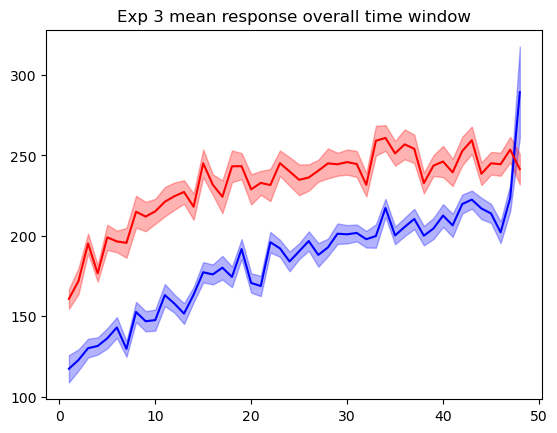

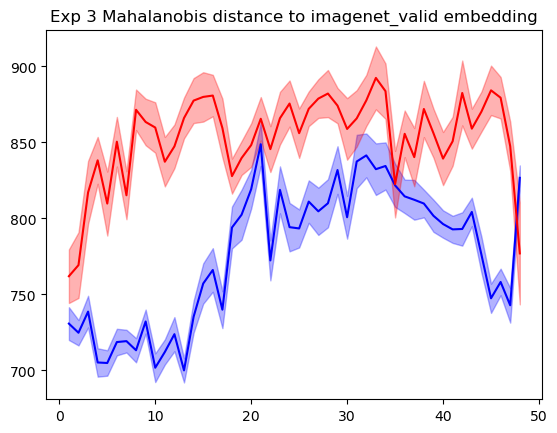

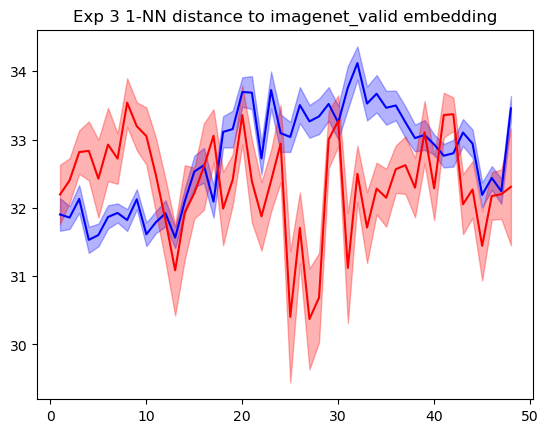

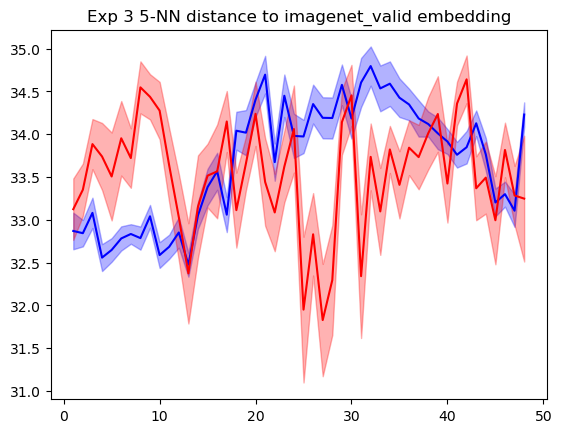

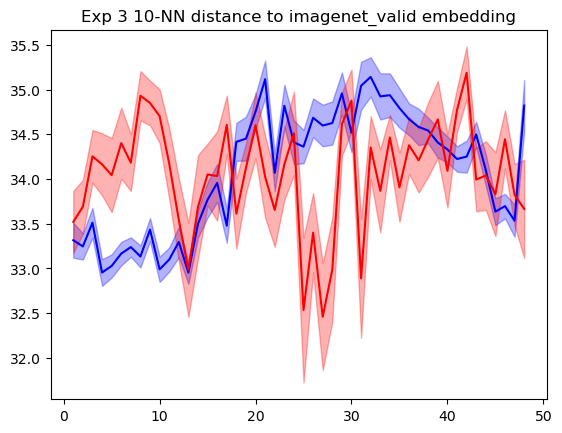

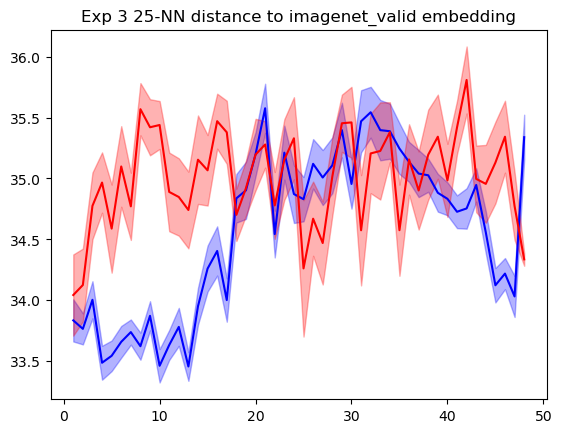

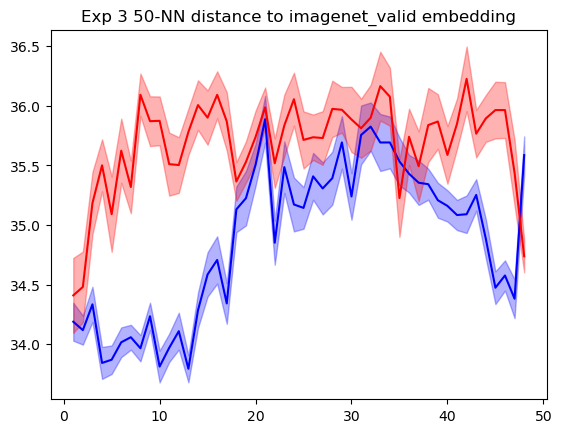

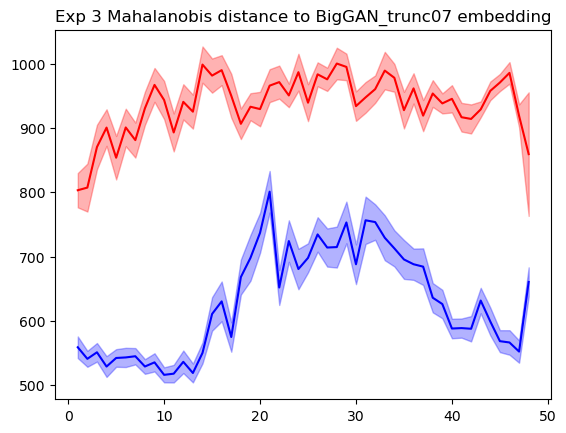

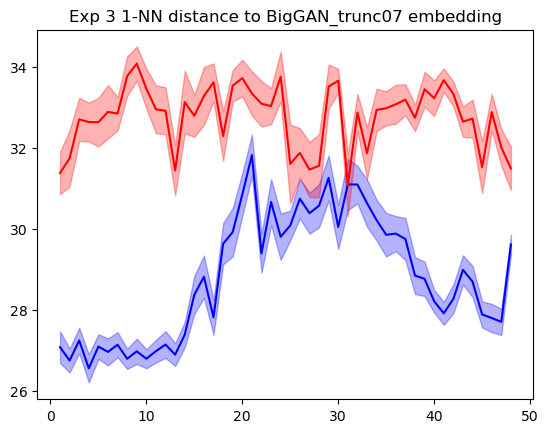

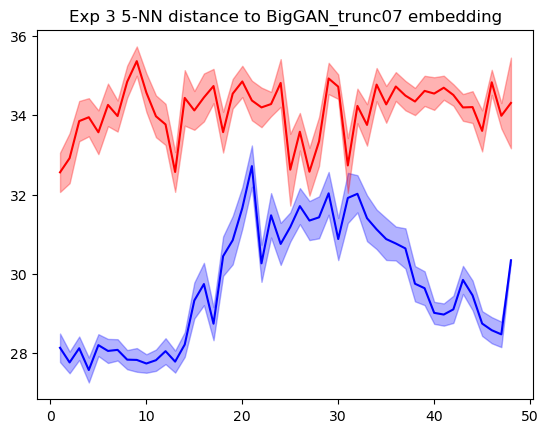

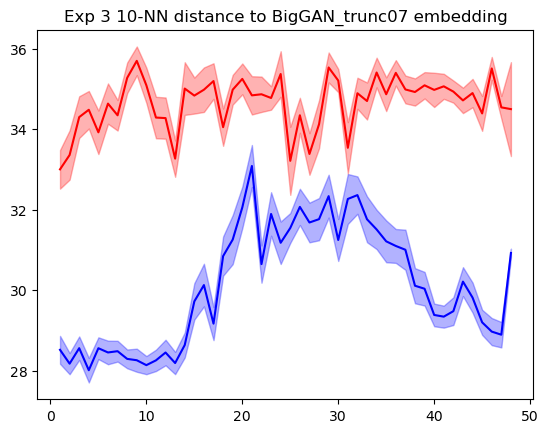

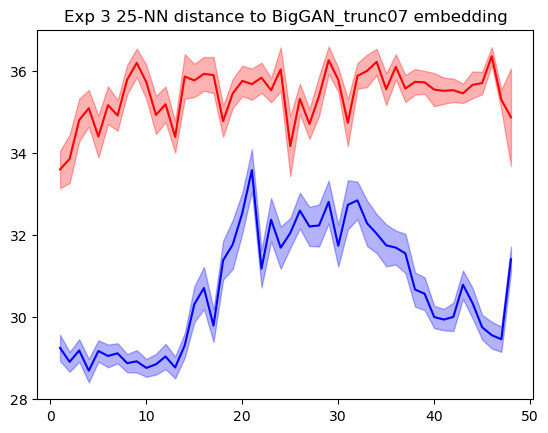

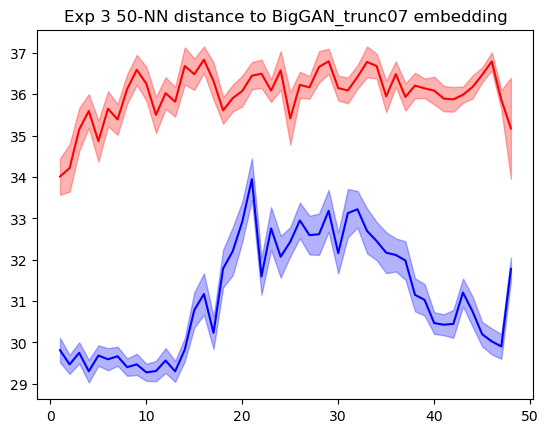

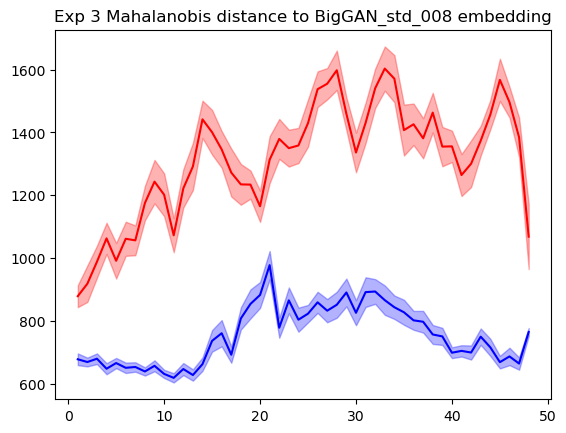

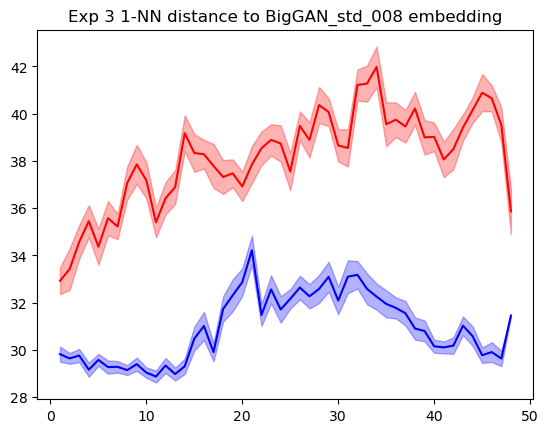

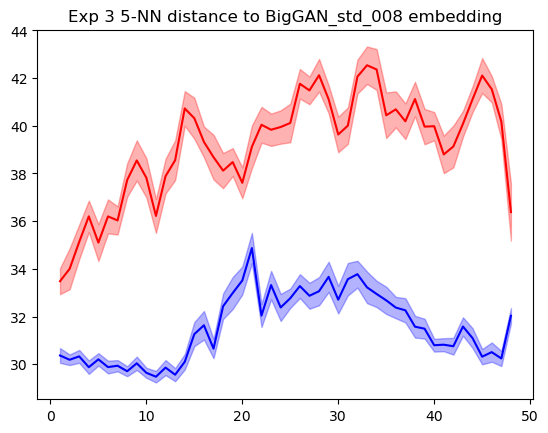

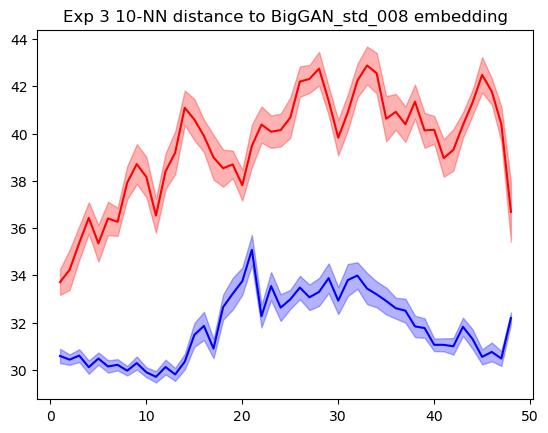

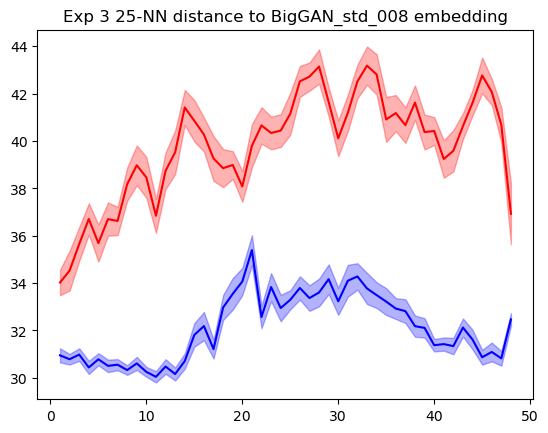

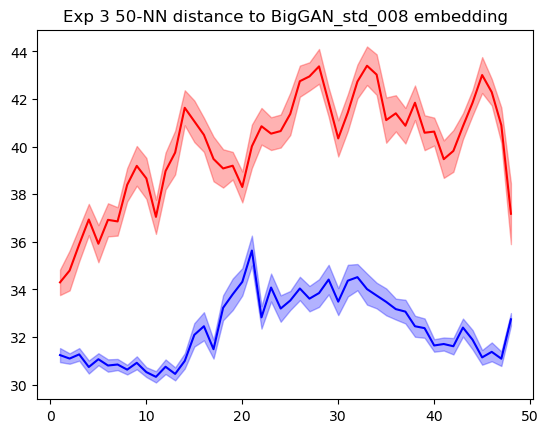

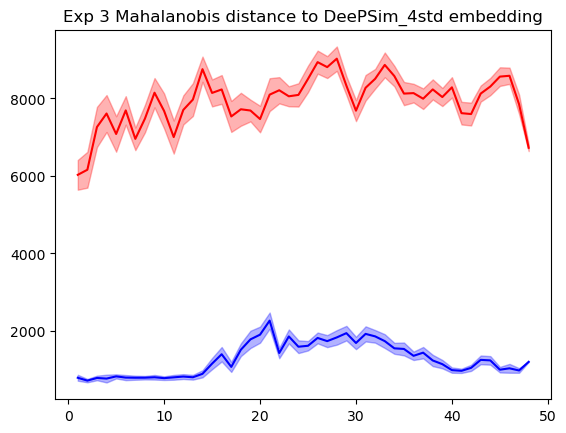

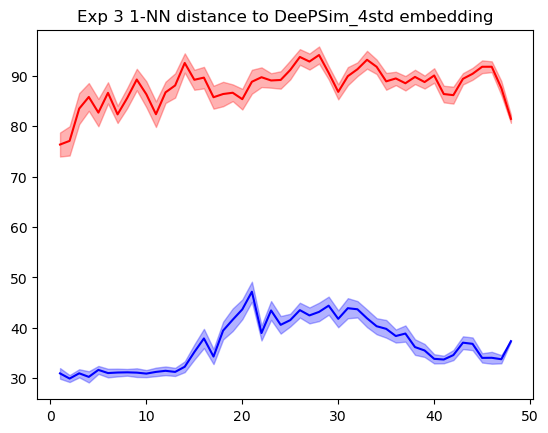

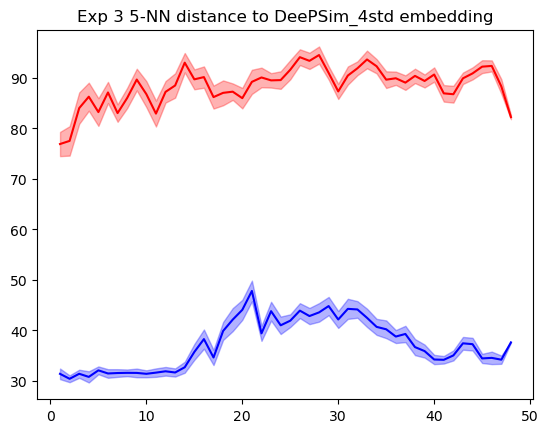

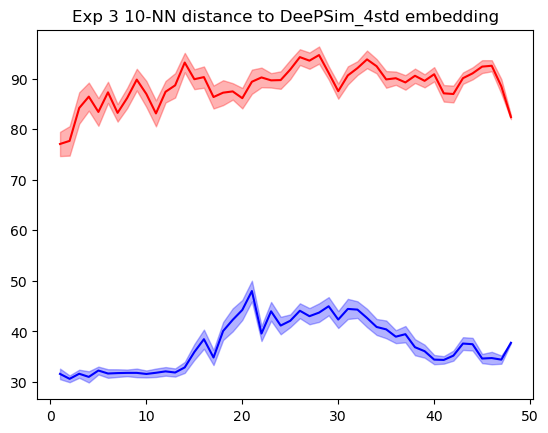

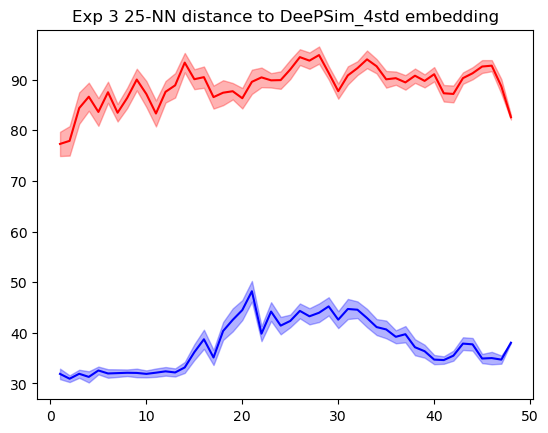

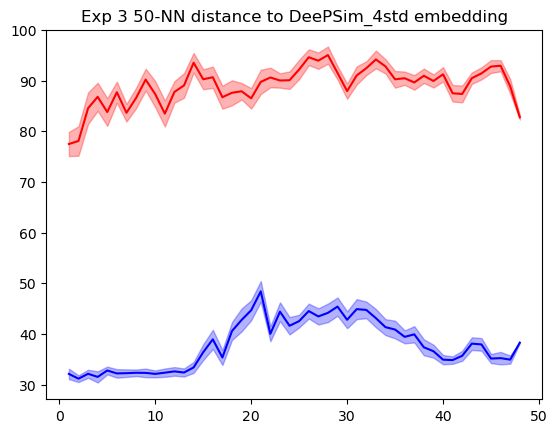

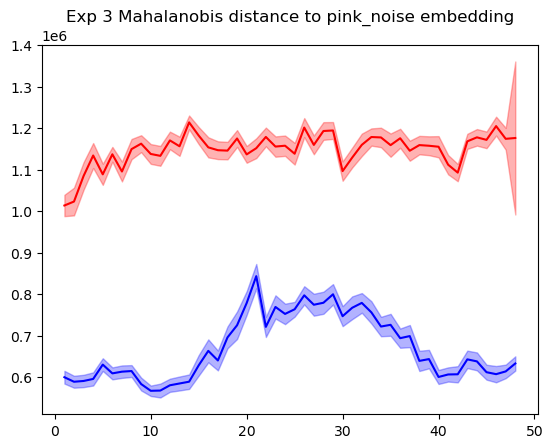

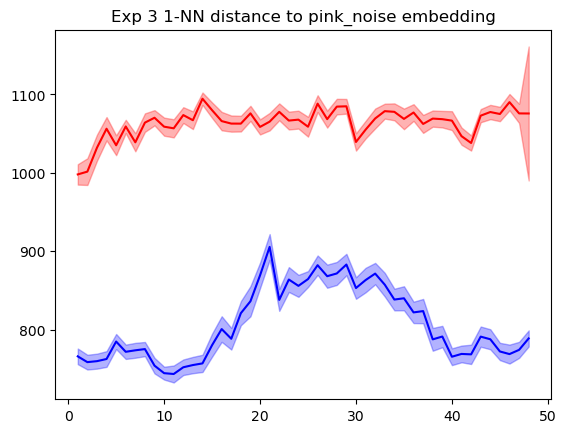

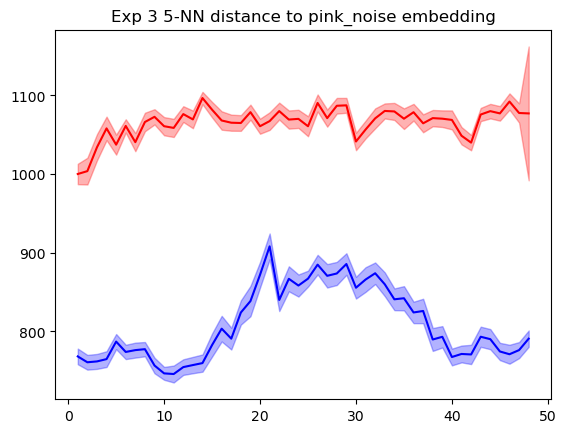

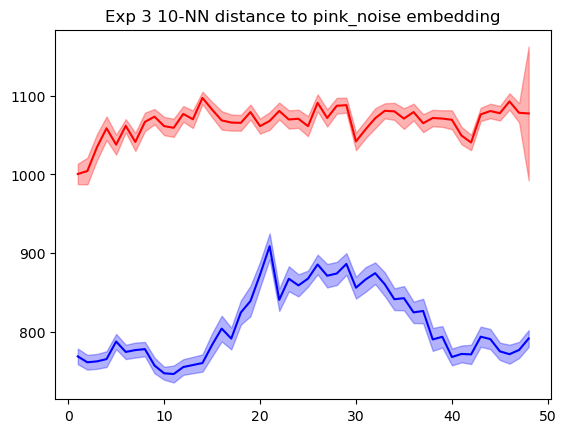

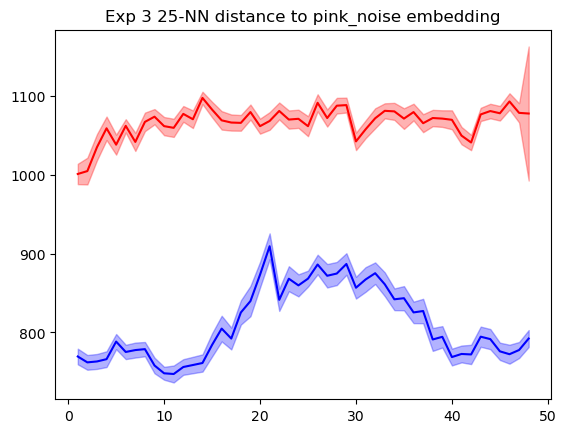

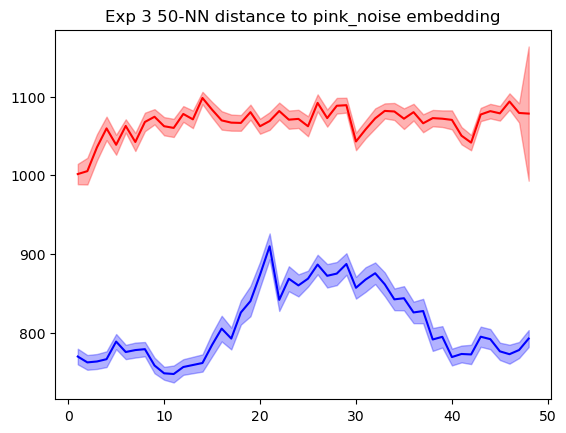

In [60]:
# Expi = 184
for Expi in [3]:#tqdm(range(1, 190+1)):
    # if ~ os.path.exists(join(Evol_embed_dir, f"Exp{Expi}_embed_act_data.pkl")):
    #     continue
    Evol_data = pkl.load(open(join(Evol_embed_dir, f"Exp{Expi:03d}_embed_act_data.pkl"), "rb"))
    embeddings0 = Evol_data["embeddings0"]
    embeddings1 = Evol_data["embeddings1"]
    imgfps0 = Evol_data["imgfps0"]
    imgfps1 = Evol_data["imgfps1"]
    resp_mat0 = Evol_data["resp_mat0"]
    resp_mat1 = Evol_data["resp_mat1"]
    gen_vec0 = Evol_data["gen_vec0"]
    gen_vec1 = Evol_data["gen_vec1"]
    plt.figure()
    plot_shaded_errorbar(gen_vec0, resp_mat0[:, 0], color="b", label="thread 0", var="sem")
    plot_shaded_errorbar(gen_vec1, resp_mat1[:, 0], color="r", label="thread 1", var="sem")
    plt.title(f"Exp {Expi} mean response overall time window")
    plt.show()
    for dataset_str in MH_eig_col:
        data_mean, data_eigvals, data_eigvecs = MH_eig_col[dataset_str]
        dataset_embed = load_dataset_embed(dataset_str)
        MHdist_0 = mahalanobis_sqdist(embeddings0.cuda(), data_mean, data_eigvecs, data_eigvals, eigfloor=1e-3).cpu()
        MHdist_1 = mahalanobis_sqdist(embeddings1.cuda(), data_mean, data_eigvecs, data_eigvals, eigfloor=1e-3).cpu()
        kNNdist_0 = dist2k_nearest_neighbor(embeddings0, dataset_embed, k_list=[1, 5, 10, 25, 50])
        kNNdist_1 = dist2k_nearest_neighbor(embeddings1, dataset_embed, k_list=[1, 5, 10, 25, 50])
        kNNMHdist_0 = dist2k_nearest_neighbor_mahalanobis(embeddings0, dataset_embed, [1, 5, 10, 25, 50],
                                                            data_eigvecs, data_eigvals, eigfloor=1e-3)
        kNNMHdist_1 = dist2k_nearest_neighbor_mahalanobis(embeddings1, dataset_embed, [1, 5, 10, 25, 50],
                                                            data_eigvecs, data_eigvals, eigfloor=1e-3)
        # raise Exception("Stop here")
        # Evol_data[f"MHdist_{dataset_str}_0"] = MHdist_0
        # Evol_data[f"MHdist_{dataset_str}_1"] = MHdist_1
        plt.figure()
        plot_shaded_errorbar(gen_vec0, MHdist_0, color="b", label="thread 0", var="sem")
        plot_shaded_errorbar(gen_vec1, MHdist_1, color="r", label="thread 1", var="sem")
        plt.title(f"Exp {Expi} Mahalanobis distance to {dataset_str} embedding")
        plt.show()
        for knn_k in [1, 5, 10, 25, 50]:
            plt.figure()
            plot_shaded_errorbar(gen_vec0, kNNMHdist_0[knn_k], color="b", label="thread 0", var="sem")
            plot_shaded_errorbar(gen_vec1, kNNMHdist_1[knn_k], color="r", label="thread 1", var="sem")
            plt.title(f"Exp {Expi} {knn_k}-NN Mahalanobis distance to {dataset_str} embedding")
            plt.show()
        # for knn_k in [1, 5, 10, 25, 50]:
        #     plt.figure()
        #     plot_shaded_errorbar(gen_vec0, kNNdist_0[knn_k], color="b", label="thread 0", var="sem")
        #     plot_shaded_errorbar(gen_vec1, kNNdist_1[knn_k], color="r", label="thread 1", var="sem")
        #     plt.title(f"Exp {Expi} {knn_k}-NN distance to {dataset_str} embedding")
        #     plt.show()


In [21]:
kNNdist_0[5].shape

torch.Size([910])

In [19]:
kNNdist_0[5].shape

torch.Size([438, 5])

In [12]:
dists = torch.cdist(embeddings0.cuda(), dataset_embed.cuda(),
                    p=2.0, compute_mode='use_mm_for_euclid_dist_if_necessary')
k_nearest = torch.topk(dists, 10, largest=False).values


In [13]:
k_nearest.shape

torch.Size([438, 10])

In [13]:
dists.shape

torch.Size([438, 50000])

In [17]:
torch.topk(dists, 20, largest=False, dim=-1).values

tensor([[26.1138, 26.2298, 26.2471,  ..., 27.3295, 27.3633, 27.3827],
        [27.0649, 27.2546, 27.3958,  ..., 29.0228, 29.0384, 29.0654],
        [26.7030, 26.8359, 27.3878,  ..., 28.1017, 28.1434, 28.1571],
        ...,
        [34.5442, 34.8168, 35.4651,  ..., 36.1671, 36.1725, 36.2736],
        [29.8034, 30.0843, 30.2442,  ..., 31.2762, 31.2865, 31.3019],
        [25.8355, 26.4108, 26.8948,  ..., 27.4858, 27.5396, 27.5504]],
       device='cuda:0')

In [18]:
torch.topk(dists, 30, largest=False, dim=-1).values

tensor([[26.1138, 26.2298, 26.2471,  ..., 27.5426, 27.5535, 27.5644],
        [27.0649, 27.2546, 27.3958,  ..., 29.1774, 29.1983, 29.2107],
        [26.7030, 26.8359, 27.3878,  ..., 28.2906, 28.3421, 28.3497],
        ...,
        [34.5442, 34.8168, 35.4651,  ..., 36.4511, 36.4523, 36.4701],
        [29.8034, 30.0843, 30.2442,  ..., 31.5507, 31.6468, 31.7481],
        [25.8355, 26.4108, 26.8948,  ..., 27.7769, 27.7984, 27.8077]],
       device='cuda:0')